# Harmonising Landsat and sentinel

* **Products used:** 


### Background 

### Description


***

## Getting started


### Load packages
Load key Python packages and any supporting functions for the analysis.

In [1]:
import datacube
import datacube.utils.rio
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr


from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.bandindices import calculate_indices

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="HLS")

### Analysis parameters


In [3]:
# Define the area of interest
latitude = 12.4917
longitude = 37.7649
buffer = 0.1


# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

# Set the range of dates for the complete sample
time = ('2018')



## View the selected location
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Landsat data

In [5]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time,
    'measurements': ['red','nir'],
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# find the right crs for the location
crs = 'EPSG:6933'

In [6]:
# load cloud-masked fractional cover using load_ard
ds = load_ard(dc=dc,
              **query,
              products=['ls8_sr'],
              align=(15, 15),
              output_crs=crs,
             )

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 46 time steps


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the x (longitude) and y (latitude) dimensions.

In [7]:
# load cloud-masked fractional cover using load_ard
ds_sentinel = load_ard(dc=dc,
              **query,
              products=['s2_l2a'],
              align=(15, 15),
              output_crs=crs,
        
             )

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 72 time steps


In [8]:
ndvi = calculate_indices(ds, 'NDVI', collection='c2', drop=True)

Dropping bands ['red', 'nir']


In [9]:
ndvi_s = calculate_indices(ds_sentinel, 'NDVI', collection='s2', drop=True)

Dropping bands ['red', 'nir']


In [10]:
land = ndvi.mean(dim=['x','y']).NDVI

In [11]:
sen = ndvi_s.mean(dim=['x','y']).NDVI

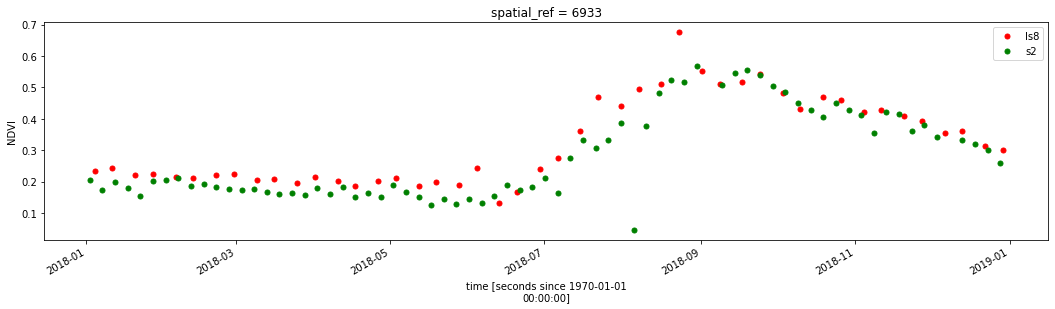

In [12]:
plt.figure(figsize=(18, 4))
land.plot(marker='.', lw=0, color='red', ms=10, label='ls8')
sen.plot(marker='.', lw=0, ms=10, color='green', label='s2')
plt.legend()

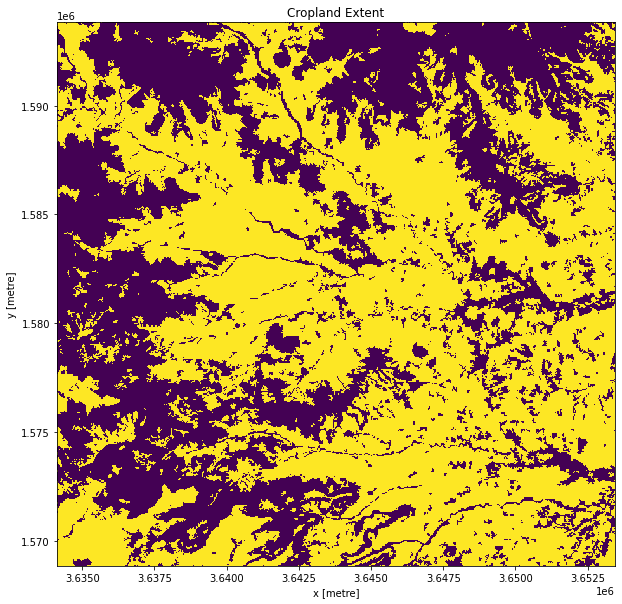

In [13]:
cm = dc.load(product='crop_mask_eastern',
            time=('2019'),
            measurements='filtered',
            resampling='nearest', 
            like=ds.geobox).filtered.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(10,10))
plt.title('Cropland Extent');

In [14]:
ndvi_crop=ndvi.where(cm, np.nan)

In [15]:
ndvi_s_crop=ndvi_s.where(cm, np.nan)

In [16]:
land_crop = ndvi_crop.mean(dim=['x','y']).NDVI

In [17]:
sen_crop = ndvi_s_crop.mean(dim=['x','y']).NDVI

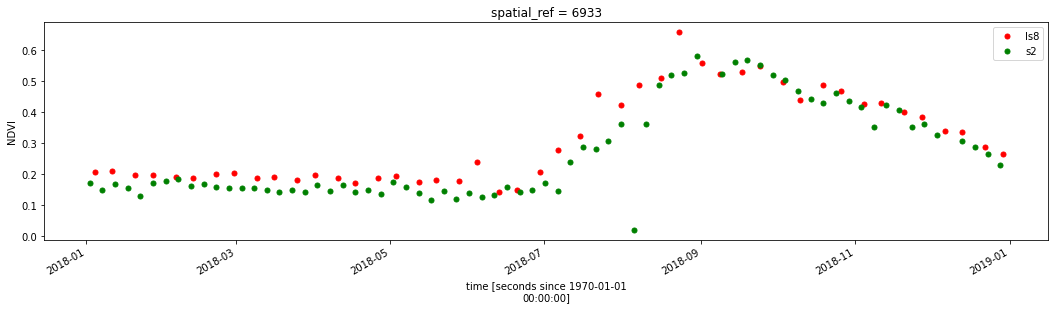

In [18]:
plt.figure(figsize=(18, 4))
land_crop.plot(marker='.', lw=0, color='red', ms=10, label='ls8')
sen_crop.plot(marker='.', lw=0, ms=10, color='green', label='s2')
plt.legend()

#### Harmonising Landsat 8 and Sentinel 2 Dataset

In [19]:
#multiplying the red band with slope and adding to intercept
ds_red_con  = (ds.red * 1.0524) + (-0.0015)

In [20]:
#multiplying the nir band with slope and adding to intercept
ds_nir_con  = (ds.nir * 0.8954) + (0.0033)

In [21]:
#calculating NDVI using converted red and nir band  
ndvi_co = (ds_nir_con  -  ds_red_con ) / (ds_nir_con + ds_red_con)

In [22]:
ndvi_ls_con = ndvi_co.mean(dim=['x','y'])

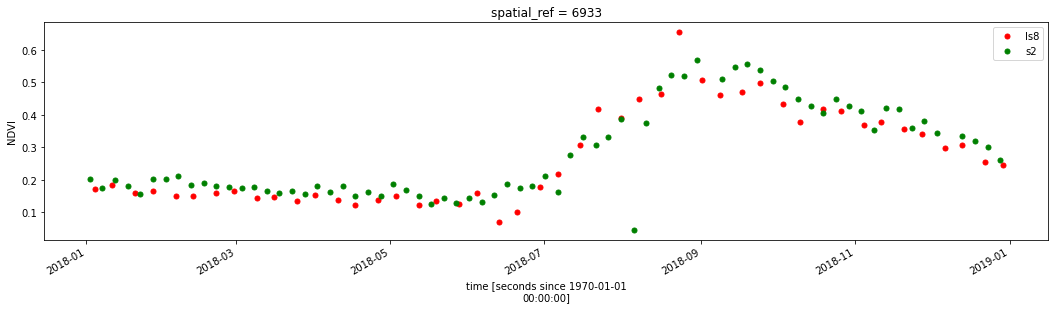

In [23]:
#Plotting the converted NDVI against sentinel
plt.figure(figsize=(18, 4))
ndvi_ls_con.plot(marker='.', lw=0, color='red', ms=10, label='ls8')
sen.plot(marker='.', lw=0, ms=10, color='green', label='s2')
plt.legend()

In [24]:
#Applying crop mask
ndvi_crop_co=ndvi_co.where(cm, np.nan)

In [25]:
ndvi_crop_ls_con = ndvi_crop_co.mean(dim=['x','y'])

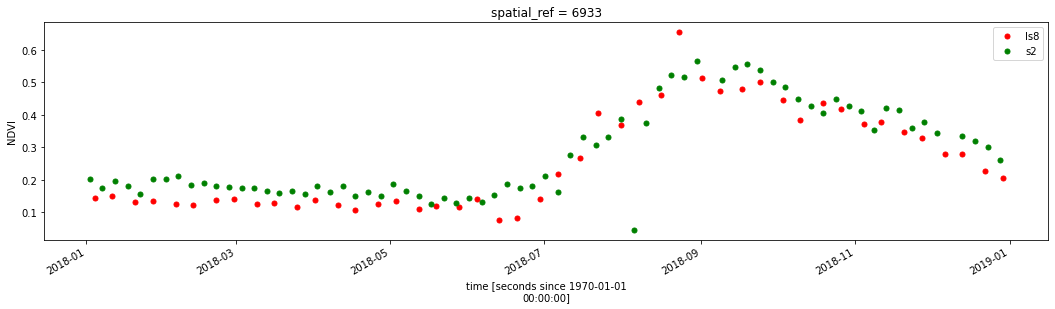

In [26]:
plt.figure(figsize=(18, 4))
ndvi_crop_ls_con.plot(marker='.', lw=0, color='red', ms=10, label='ls8')
sen.plot(marker='.', lw=0, ms=10, color='green', label='s2')
plt.legend()